*This notebook made by:*

**Farnaz Baksh**

**Matevz Zorec**

During our **Introduction to Data Science course** in Autumn of 2021

Course Code: *LTAT.02.002*

Project title:

>**Team B1: UT Student Profiling based on Moodle Log Data**

*18. 11. 2021  -  15.12.2021*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from google_trans_new import google_translator 
from multiprocessing.dummy import Pool as ThreadPool
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import os
from os import listdir
from os.path import isfile, join
import threading

translator = google_translator(timeout=5)

In [2]:
translate_text = translator.translate('Stvar deluje in pocasi prevaja.',lang_tgt='en')  
print(translate_text)

The thing works and slowly translates. 


[how to print all dataframe values...](https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/)

In [3]:
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
########################
#pd.set_option('display.max_colwidth', -1)

[load csv files 10x faster](https://towardsdatascience.com/%EF%B8%8F-load-the-same-csv-file-10x-times-faster-and-with-10x-less-memory-%EF%B8%8F-e93b485086c7)

**Goal:** identify students who may be struggling based on their early activities


**Goal:** predict the student’ final grades in the course


**Goal:** discover common activity patterns of the students and create profiles of typical students (from activity logs).


In [4]:
grades_og = pd.read_excel("02-05 Hinded.xlsx") # all files we are operating with are excel files and not csv

In [5]:
grades = grades_og.copy() # Hinded == Grades
#grades.head()

In [6]:
#Overall memory consumption of the data
grades_og.memory_usage(deep=True).sum()

1563166

extract student first name, last name, email, ID and substitute custom ID from index in gradebook

In [7]:
indexi = []
for index in grades_og.index.values:
    indexi.append(index)
indexID = pd.DataFrame(columns=['indexID'], data=indexi)

grades_og.insert(0, "indexID", indexID)
students = grades_og[['indexID', 'Eesnimi', 'Perenimi', 'ID-number', 'Meiliaadress']].copy()
grades = grades_og.drop(columns=['Eesnimi', 'Perenimi', 'ID-number', 'Meiliaadress'], axis=1)
#grades.head()

##### print all columns with null values...

In [8]:
counter = 0
for column in grades:
    if grades[column].isnull().all():
        counter += 1
        print(column)
print(counter)

Ülesanne:1. KT 5.01 lisajäreltöö logide ja video esitamine (Punktid)
Ülesanne:1. KT 25.01 lisajäreltöö logide ja video esitamine (Punktid)
Ülesanne:2. KT 6.01 lisajäreltöö logide ja video esitamine (Punktid)
Ülesanne:2. KT 26.01 lisajäreltöö logide ja video esitamine (Punktid)
Ülesanne:8.01 eksami logide ja video esitamine (Punktid)
Ülesanne:14.01 eksami logide ja video esitamine (Punktid)
Ülesanne:27.01 eksami logide ja video esitamine (Punktid)
Ülesanne:Näidiseksami logide ja video esitamine (Punktid)
8


##### confirm all columns with null values with value_counts

In [9]:
NaN_columns_check = ['Ülesanne:1. KT 5.01 lisajäreltöö logide ja video esitamine (Punktid)',
                     'Ülesanne:1. KT 25.01 lisajäreltöö logide ja video esitamine (Punktid)',
                     'Ülesanne:2. KT 6.01 lisajäreltöö logide ja video esitamine (Punktid)',
                     'Ülesanne:2. KT 26.01 lisajäreltöö logide ja video esitamine (Punktid)',
                     'Ülesanne:8.01 eksami logide ja video esitamine (Punktid)',
                     'Ülesanne:14.01 eksami logide ja video esitamine (Punktid)',
                     'Ülesanne:27.01 eksami logide ja video esitamine (Punktid)',
                     'Ülesanne:Näidiseksami logide ja video esitamine (Punktid)']
for entry in NaN_columns_check:
    print(grades[entry].value_counts())
len(NaN_columns_check)

Series([], Name: Ülesanne:1. KT 5.01 lisajäreltöö logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:1. KT 25.01 lisajäreltöö logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:2. KT 6.01 lisajäreltöö logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:2. KT 26.01 lisajäreltöö logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:8.01 eksami logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:14.01 eksami logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:27.01 eksami logide ja video esitamine (Punktid), dtype: int64)
Series([], Name: Ülesanne:Näidiseksami logide ja video esitamine (Punktid), dtype: int64)


8

In [10]:
grades.drop(columns=NaN_columns_check, axis=1, inplace=True)
#grades

In [11]:
pool = ThreadPool(16) # Threads
def request(text):
    translate_text = translator.translate(text.strip(), lang_src='et', lang_tgt='en')
    return translate_text
time1 = time.time()
grades_en = grades.copy()
try:
    grades_en.columns = pool.map(request, grades_en.columns.values)
    students.columns = pool.map(request, students.columns.values)
except Exception as e:
    raise e
finally:
    pool.close()
    pool.join()
time2 = time.time()
print(f"Multithreaded translation of {len(grades_en.columns)} and {len(students.columns)} column names took {round(time2 - time1)}s")

Multithreaded translation of 100 and 5 column names took 3s


In [12]:
# translated column names
en_columns = grades_en.columns.values
#en_columns

##### replace dashes (-) in data with 0.0 for consistency of formatting

In [13]:
for column in en_columns:
    grades_en.loc[grades_en[column] == "-", column] = 0.0
#grades_en

In [14]:
for column in en_columns:
    if column != 'index ':
        print(grades_en[column].value_counts())
        print("\n\n")

0.50    201
0.00     25
0.46     24
0.48     19
0.47     17
0.40     11
0.43      8
0.42      6
0.45      6
0.39      4
0.35      4
0.38      3
0.04      3
0.41      2
0.34      2
0.44      2
0.49      1
0.36      1
0.33      1
0.30      1
0.37      1
Name: Test: 1. Weekly test (points) , dtype: int64



0.50    142
0.00     36
0.49     26
0.48     22
0.46     20
0.45     20
0.44     18
0.43     14
0.39      9
0.40      9
0.41      6
0.30      5
0.38      3
0.33      3
0.25      2
0.03      1
0.29      1
0.01      1
0.19      1
0.35      1
0.18      1
0.36      1
Name: Test: 2. Weekly test (points) , dtype: int64



0.50    89
0.00    34
0.48    29
0.45    29
0.43    22
0.49    13
0.40    11
0.44    10
0.35     8
0.30     8
0.46     8
0.39     7
0.47     7
0.38     7
0.41     7
0.36     6
0.42     5
0.31     4
0.28     4
0.34     4
0.20     3
0.25     3
0.32     3
0.26     3
0.29     3
0.27     2
0.06     1
0.22     1
0.21     1
0.18     1
0.03     1
0.23     1
0.16     1
0.33     1
0.

Name: Task: Submit a description of the project (points) , dtype: int64

Name: Task: Registration for Eeliques (points) , dtype: int64

Name: Access to the exam (points) , dtype: int64

In [15]:
print(grades_en['Access to the exam (points) '].value_counts())
print("\n")
print(grades_en['Task: Registration for Eeliques (points) '].value_counts())
print("\n")
print(grades_en['Task: Submit a description of the project (points) '].value_counts())

jah    297
ei      45
Name: Access to the exam (points) , dtype: int64


0.0           311
arvestatud     31
Name: Task: Registration for Eeliques (points) , dtype: int64


arvestatud         240
0.0                 97
mittearvestatud      5
Name: Task: Submit a description of the project (points) , dtype: int64


In [16]:
phrases = ['jah', 'ei', 'arvestatud', 'mittearvestatud']
column_set = ['Access to the exam (points) ', 'Task: Registration for Eeliques (points) ', 'Task: Submit a description of the project (points) ']
phrases_en = translator.translate(phrases, lang_src='et', lang_tgt='en')
phrases_en

"['yes', 'no', 'consideration', 'non-invalidated'] "

In [17]:
grades_temp = grades_en.copy()
for column in column_set:
    grades_temp.loc[grades_temp[column] == 'jah', column] = 'yes'
    grades_temp.loc[grades_temp[column] == 'ei', column] = 'no'
    grades_temp.loc[grades_temp[column] == 'arvestatud', column] = 'consideration'
    grades_temp.loc[grades_temp[column] == 'mittearvestatud', column] = 'non-invalidated'

In [18]:
grades_en = grades_temp

In [19]:
grades_en_cpy = grades_en.copy()
rows = len(grades_en)
test = np.ones(rows)

grades_en_cpy.insert(len(grades_en_cpy.columns), "Grade (letter)", (test))

F_student = []
rows_to_drop = []
for row in range(0, rows):
    grade = int(grades_en_cpy['Grade (points) '].loc[row])

    if (grade >= 1) and (grade <= 49):
        grades_en_cpy['Grade (letter)'].loc[row] = 'F'
        F_student.append(row)
    
    elif (grade >= 50) and (grade <= 59):
        grades_en_cpy['Grade (letter)'].loc[row] = 'E'
    
    elif (grade >= 60) and (grade <= 69):
        grades_en_cpy['Grade (letter)'].loc[row] = 'D'
    
    elif (grade >= 70) and (grade <= 79):
        grades_en_cpy['Grade (letter)'].loc[row] = 'C'
    
    elif (grade >= 80) and (grade <= 89):
        grades_en_cpy['Grade (letter)'].loc[row] = 'B'
    
    elif (grade >= 90) and (grade <= 100):
        grades_en_cpy['Grade (letter)'].loc[row] = 'A'
    
    elif grade == 0:
        grades_en_cpy['Grade (letter)'].loc[row] = 0
        rows_to_drop.append(row)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
students['Grade (letter)'] = grades_en_cpy[['Grade (letter)']].copy()

In [21]:
print(f"These students dropped the course or something: \n{rows_to_drop}\n And we found this many of them: \n{len(rows_to_drop)}")
grades_en_cpy.drop(labels=rows_to_drop, axis=0, inplace=True)
grades_en = grades_en_cpy #
grades_en.shape

These students dropped the course or something: 
[4, 7, 10, 13, 22, 31, 36, 37, 44, 45, 55, 56, 94, 101, 110, 112, 122, 137, 152, 167, 178, 183, 188, 197, 198, 204, 205, 210, 213, 225, 226, 229, 230, 232, 233, 234, 235, 258, 272, 274, 279, 288, 289, 303, 305, 311, 322, 324, 336]
 And we found this many of them: 
49


(293, 101)

In [22]:
students.to_csv('Students_Name_Surname_ID_email_indexIDkey.csv')
print("Saved list of students to Students_Name_Surname_ID_email_indexIDkey.csv!")

Saved list of students to Students_Name_Surname_ID_email_indexIDkey.csv!


In [23]:
students_filtered = students.drop(labels=rows_to_drop, axis=0)

students_filtered.to_csv('FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv')
print("Saved list of students to FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv!")

Saved list of students to FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv!


In [24]:
students_filtered.shape

(293, 6)

Students who got an F as a final grade because they did one of the following:

- dropped out early
- gave up
- passed course and did not attend due to other reasons

...are removed from the gradebook from hereon out...

[Computer Programming course 2020/21 fall](https://courses.cs.ut.ee/2020/programmeerimine/fall)

An introductory programming course designed to provide a basic understanding of the basic structures of programming and basic skills in building algorithms and programs. The course does not require prior knowledge other than general computer skills. Before each internship, read the relevant topic in the textbook and solve and submit homework. In the internship, the main things are reviewed and more tasks are solved.

Schedule Lectures: online, conditional time on Tuesdays 12:15 Internships: Thursdays 10:15, 12:15 and 16:15, a total of 20 groups Consultation: Wednesdays at 18:15 in room 1008 Textbook: http://progeopik.cs.ut.ee/

Each test can be completed once during the semester, the last result will be taken into account. The course also has a project that starts after the first test, and an exam in January.

*to get 1p, students had to solve homework and practice session tasks*

*before each practice session, they had to read the topic in the textbook, then solve and submit the homework*

*during the practice session, main topics are reviewed and then more tasks are solved*

To receive points for homework, homework must be submitted through Moodle before the internship, no later than 8 am on Thursday morning. Active participation in the internship is important for getting points for the internship. In order to receive a point for an additional task, your solution must be explained to the internship supervisor. All lower limits must be met to receive a positive grade on the course. Rating scale: A [90-110], B [80-90), C [70-80), D [60-70), E [50-60), F [0-50).

Learning outcomes Student who has completed the course: knows and is able to use basic programming constructions: variable, expression, attribute, conditional, loop, subroutine, recursion, data exchange with user and files; knows the basic data types and structures (integers and floating point numbers, true values, words, sequences, etc.) and is able to use the corresponding standard operations; is able to analyze and explain in detail the course of work of the program and to change, supplement and further develop the program; is able to create an algorithm corresponding to a simpler task, compile and correctly format a solution program, and debug and test it; is able to implement programming projects in cooperation with teammates. If you have any questions, send a letter to the course forum in Moodle or contact the internship supervisor.

### which students belong to which group?

#### who is a tutor/lecturer? ==> likely anyone not on the gradebook list or list of students...

Early grade activity columns?... **up to ~week 6 (exam week, so add week 7)**

*structure recap: weekly tests & weekly homeworks* 

                                      'index ', 'Test: 1. Weekly test (points) ', 
                                      'Test: 2. Weekly test (points) ',
                                      'Test: 3. Weekly test (points) ',
                                      'Test: 4. Weekly test (points) ',
                                      'Test: 5. Weekly test (points) ',
                                      'Test: 7. Weekly test (points) ', 
                                      "VPL Exercise: 1. week's homework (points) ",
                                      "VPL Exercise: 2. week's homework (points) ",
                                      "VPL Exercise: 3. week's homework (points) ",
                                      "VPL Exercise: 4. week's homework (points) ", 
                                      "VPL Exercise: 5. week's homework (points) ",
                                      "VPL Exercise: 7. week's homework (points) ",
                                      'Total result (points) ',
                                      'Grade (points) ', 
                                      'Grade (letter)'

In [25]:
grades_data_cpy = grades_en.copy()

grades_data_cpy.sort_values(by=['Total result (points) '], axis=0, ascending=False, inplace=True, ignore_index=True)

grades_data_subset = grades_data_cpy[['index ', 
                                      'Test: 1. Weekly test (points) ', 
                                      'Test: 2. Weekly test (points) ',
                                      'Test: 3. Weekly test (points) ',
                                      'Test: 4. Weekly test (points) ',
                                      'Test: 5. Weekly test (points) ',
                                      'Test: 7. Weekly test (points) ', 
                                      "VPL Exercise: 1. week's homework (points) ",
                                      "VPL Exercise: 2. week's homework (points) ",
                                      "VPL Exercise: 3. week's homework (points) ",
                                      "VPL Exercise: 4. week's homework (points) ", 
                                      "VPL Exercise: 5. week's homework (points) ",
                                      "VPL Exercise: 7. week's homework (points) ",
                                      'Total result (points) ',
                                      'Grade (points) ', 
                                      'Grade (letter)']]
grades_data_subset

,index,Test: 1. Weekly test (points),Test: 2. Weekly test (points),Test: 3. Weekly test (points),Test: 4. Weekly test (points),Test: 5. Weekly test (points),Test: 7. Weekly test (points),VPL Exercise: 1. week's homework (points),VPL Exercise: 2. week's homework (points),VPL Exercise: 3. week's homework (points),VPL Exercise: 4. week's homework (points),VPL Exercise: 5. week's homework (points),VPL Exercise: 7. week's homework (points),Total result (points),Grade (points),Grade (letter)
0,282,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,110.00,100.00,A
1,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,109.40,100.00,A
2,266,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,108.50,100.00,A
3,270,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,108.50,100.00,A
4,328,0.5,0.5,0.46,0.49,0.48,0.48,0.5,0.5,0.5,0.5,0.5,0.5,108.00,100.00,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,78,0.48,0.45,0.0,0.0,0.5,0.43,0.5,0.5,0.0,0.0,0.3,0.2,52.50,52.50,E
289,38,0.5,0.5,0.5,0.5,0.5,0.3,0.5,0.5,0.5,0.5,0.5,0.5,52.23,52.23,E
290,227,0.46,0.46,0.48,0.35,0.4,0.45,0.5,0.4,0.5,0.5,0.4,0.1,52.13,52.13,E
291,119,0.47,0.33,0.06,0.3,0,0.42,0.5,0.0,0.0,0.0,0.0,0.0,52.05,52.05,E


## [calculate new column as mean of other columns with pandas](https://stackoverflow.com/questions/48366506/calculate-new-column-as-the-mean-of-other-columns-pandas/48366525)

We will use the first 6-ish weeks worth of data [because this paper saw this was that crucial first bit of the semester](https://dl.acm.org/doi/pdf/10.1145/3430665.3456320)

In [26]:
grades_data_subset['Average of Homeworks'] = grades_data_subset[["VPL Exercise: 1. week's homework (points) ",
                                                                 "VPL Exercise: 2. week's homework (points) ",
                                                                 "VPL Exercise: 3. week's homework (points) ",
                                                                 "VPL Exercise: 4. week's homework (points) ",
                                                                 "VPL Exercise: 5. week's homework (points) ",
                                                                 "VPL Exercise: 7. week's homework (points) "]].mean(axis=1)

<ipython-input-26-ac422a244508>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grades_data_subset['Average of Homeworks'] = grades_data_subset[["VPL Exercise: 1. week's homework (points) ",


In [27]:
grades_data_subset['Average of Tests'] = grades_data_subset[['Test: 1. Weekly test (points) ',
                                                             'Test: 2. Weekly test (points) ',
                                                             'Test: 3. Weekly test (points) ',
                                                             'Test: 4. Weekly test (points) ',
                                                             'Test: 5. Weekly test (points) ',
                                                             'Test: 7. Weekly test (points) ']].mean(axis=1)

<ipython-input-27-9617772a53d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grades_data_subset['Average of Tests'] = grades_data_subset[['Test: 1. Weekly test (points) ',


In [28]:
grades_data_subset['Average of both Tests & Homeworks'] = grades_data_subset[['Average of Tests',
                                                                              'Average of Homeworks']].mean(axis=1)


<ipython-input-28-0a14b063ff2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grades_data_subset['Average of both Tests & Homeworks'] = grades_data_subset[['Average of Tests',


In [29]:
grades_data_subset

,index,Test: 1. Weekly test (points),Test: 2. Weekly test (points),Test: 3. Weekly test (points),Test: 4. Weekly test (points),Test: 5. Weekly test (points),Test: 7. Weekly test (points),VPL Exercise: 1. week's homework (points),VPL Exercise: 2. week's homework (points),VPL Exercise: 3. week's homework (points),VPL Exercise: 4. week's homework (points),VPL Exercise: 5. week's homework (points),VPL Exercise: 7. week's homework (points),Total result (points),Grade (points),Grade (letter),Average of Homeworks,Average of Tests,Average of both Tests & Homeworks
0,282,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,110.00,100.00,A,0.500000,0.500000,0.500000
1,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,109.40,100.00,A,0.500000,0.500000,0.500000
2,266,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,108.50,100.00,A,0.500000,0.500000,0.500000
3,270,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,108.50,100.00,A,0.500000,0.500000,0.500000
4,328,0.5,0.5,0.46,0.49,0.48,0.48,0.5,0.5,0.5,0.5,0.5,0.5,108.00,100.00,A,0.500000,0.485000,0.492500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,78,0.48,0.45,0.0,0.0,0.5,0.43,0.5,0.5,0.0,0.0,0.3,0.2,52.50,52.50,E,0.250000,0.310000,0.280000
289,38,0.5,0.5,0.5,0.5,0.5,0.3,0.5,0.5,0.5,0.5,0.5,0.5,52.23,52.23,E,0.500000,0.466667,0.483333
290,227,0.46,0.46,0.48,0.35,0.4,0.45,0.5,0.4,0.5,0.5,0.4,0.1,52.13,52.13,E,0.400000,0.433333,0.416667
291,119,0.47,0.33,0.06,0.3,0,0.42,0.5,0.0,0.0,0.0,0.0,0.0,52.05,52.05,E,0.083333,0.263333,0.173333


In [30]:
grades_data_subset.columns

Index(['index ', 'Test: 1. Weekly test (points) ',
       'Test: 2. Weekly test (points) ', 'Test: 3. Weekly test (points) ',
       'Test: 4. Weekly test (points) ', 'Test: 5. Weekly test (points) ',
       'Test: 7. Weekly test (points) ',
       'VPL Exercise: 1. week's homework (points) ',
       'VPL Exercise: 2. week's homework (points) ',
       'VPL Exercise: 3. week's homework (points) ',
       'VPL Exercise: 4. week's homework (points) ',
       'VPL Exercise: 5. week's homework (points) ',
       'VPL Exercise: 7. week's homework (points) ', 'Total result (points) ',
       'Grade (points) ', 'Grade (letter)', 'Average of Homeworks',
       'Average of Tests', 'Average of both Tests & Homeworks'],
      dtype='object')

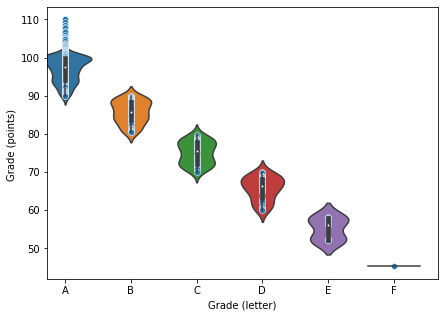

In [429]:
sns.violinplot(x= 'Grade (letter)', y= 'Grade (points) ', data = grades_data_subset)
sns.scatterplot(data = grades_data_subset, x= 'Grade (letter)', y= 'Total result (points) ')
plt.gcf().set_size_inches(7,5)

Looks like A, B, C, D & E grades have distributions that make sense but F is weird. 

As though people got an A or B grade or even a C, D and E but still assigned an F?

EDIT: looks like there was a preselector exam that once students filled it they simply passed the course and their grade may have been input to OIS without ever being applied to this gradebook... applied filtering and removed these students and thus cleaned the plot above

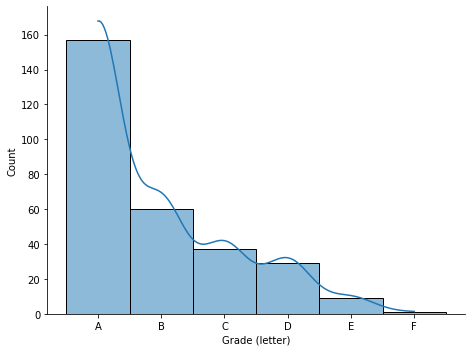

In [428]:
ax = sns.displot(grades_data_subset, x = 'Grade (letter)', kde = True)
plt.gcf().set_size_inches(7,5)

Distribution to show how many students got which grade.

Shows almost ~160 students got an A and then about 50, 60, 40, 30 and 10 students got an F, B, C, D, E respectively.

In [33]:
grade_set = grades_data_subset['Grade (letter)'].value_counts()
print(f"~{round((grade_set[0]/342)*100, 1)}% of all students got an A\n")
print(f"~{round(((grade_set[1])/342)*100, 1)}% got a B\n")
print(f"~{round(((grade_set[2])/342)*100, 1)}% got a C\n")
print(f"~{round(((grade_set[3])/342)*100, 1)}% got a D\n")
print(f"~{round(((grade_set[4])/342)*100, 1)}% got an E\n")
print(f"~{round(((grade_set[5])/342)*100, 1)}% got an F\n")
print(grade_set)

~45.9% of all students got an A

~17.5% got a B

~10.8% got a C

~8.5% got a D

~2.6% got an E

~0.3% got an F

A    157
B     60
C     37
D     29
E      9
F      1
Name: Grade (letter), dtype: int64


#### So E is the rarest grade while A the most common grade among the students.

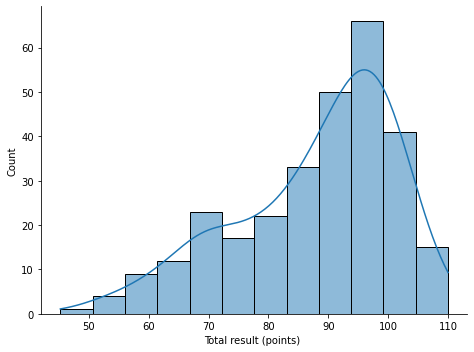

In [427]:
ax = sns.displot(grades_data_subset, x = 'Total result (points) ', kde = True)
plt.gcf().set_size_inches(7,5)

More grade distributions to support the previous conclusions.


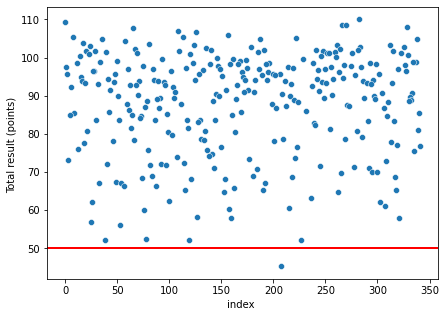

In [426]:
graf = sns.scatterplot(data = grades_data_subset, x = 'index ', y = 'Total result (points) ', legend="full")
graf.axhline(50, color='red', linewidth=2)
plt.gcf().set_size_inches(7,5)

##### Final plot sanity check to confirm majority of students passed this course. Red line denotes minimum pass mark of 50%.

Showcase comparison of average test scores vs total result points. Add lines to show pass mark.

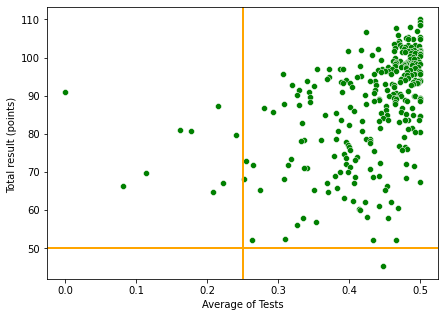

In [425]:
graf = sns.scatterplot(data = grades_data_subset, x = 'Average of Tests', y = 'Total result (points) ', legend="full", color='green')
graf.axhline(50, color='orange', linewidth=2)
graf.axvline(0.25, color='orange', linewidth=2)
plt.gcf().set_size_inches(7,5)

Most students got good results on the tests but a few had worse results and despite that still got a good final grade.

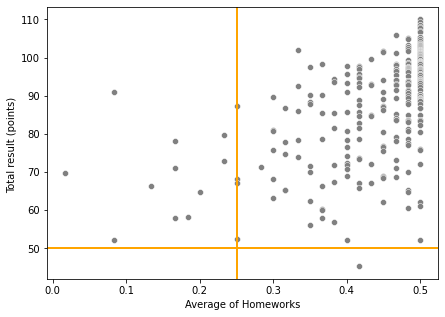

In [424]:
graf = sns.scatterplot(data = grades_data_subset, x = 'Average of Homeworks', y = 'Total result (points) ', legend="full", color='grey')
graf.axhline(50, color='orange', linewidth=2)
graf.axvline(0.25, color='orange', linewidth=2)
plt.gcf().set_size_inches(7,5)

This comparison shows students who did well with their homeworks were more likely to get a better final grade.

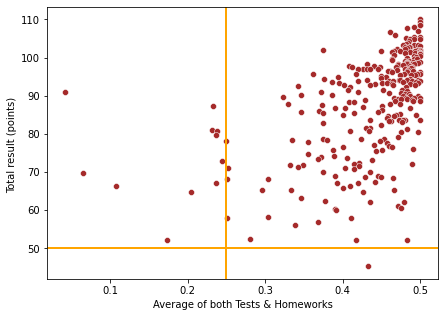

In [423]:
graf = sns.scatterplot(data = grades_data_subset, x = 'Average of both Tests & Homeworks', y = 'Total result (points) ', legend="full", color='brown')
graf.axhline(50, color='orange', linewidth=2)
graf.axvline(0.25, color='orange', linewidth=2)
plt.gcf().set_size_inches(7,5)

This last comparison checks how both tests and homeworks impact final grade performance.

# Key takeaways from this analysis:

- It seems that there are not many students in this course who struggle but nonetheless there are exceptions.

- Additionally, higher averages on homeworks and tests are also correlated with a higher final grade.

- The opposite also holds true: lower averages result in lower grade.

- It seems clear that it would be hard to identify a struggling student based on this data alone...

- we can try to build a model just using these early results as features

- we can also try to add to this same model by expanding these features with activity profiles for these students

# Goal 2: Predicting final grades


We want to see just how successful would a model be in predicting final grades based on early scores alone.

Then we want to try and extract common activity patterns and see if we could improve on the models success.

We assume these activity patterns would correlate to the final grade.


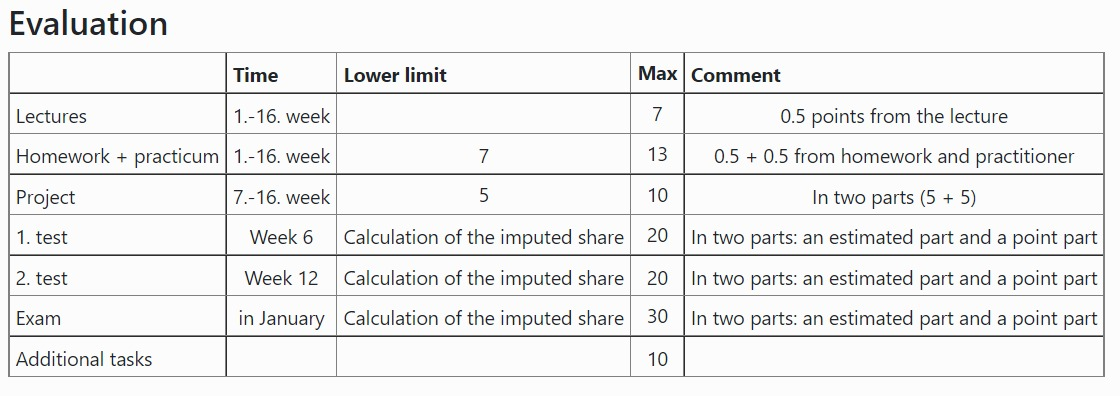

In [39]:
grades_en

,index,Test: 1. Weekly test (points),Test: 2. Weekly test (points),Test: 3. Weekly test (points),Test: 4. Weekly test (points),Test: 5. Weekly test (points),Test: 6. Weekly test (points),Test: 7. Weekly test (points),Test: 8. Weekly test (points),Test: 9. Weekly test (points),Test: 10. Weekly test (points),Test: 11. Weekly test (points),Test: 12. Weekly test (points),Test: 13. Weekly test (points),Test: 14. Weekly test (points),Test: 15. Weekly test (points),Test: 16. Weekly test (points),Total video lectures (points),VPL Exercise: 1. week's homework (points),VPL Exercise: Practice submission (points),VPL Exercise: 2. week's homework (points),VPL Exercise: Practice submission (points) .1,VPL Exercise: 3. week's homework (points),VPL Exercise: Practice submission (points) .2,VPL Exercise: 4. week's homework (points),VPL Exercise: Presentation of Practice (points) .3,VPL Exercise: 5. week's homework (points),VPL Exercise: Practice submission (points) .4,VPL Exercise: 7. week's homework (points),VPL Exercise: Practice submission (points) .5,VPL Exercise: 8. week's homework (points),VPL Exercise: Practice submission (points) .6,VPL Exercise: 9. week's homework (points),VPL Exercise: Practice submission (points) .7,VPL Exercise: 10. week's homework (points),VPL Exercise: Practice submission (points) .8,VPL Exercise: 11. week's homework (points),VPL Exercise: Practice submission (points) .9,VPL Exercise: 13. week's homework (points),VPL Exercise: Practice submission (points) .10,VPL Exercise: 14. week's homework (points),VPL Exercise: Practice submission (points) .11,VPL Exercise: 15. week's homework (points),VPL Exercise: Practice submission (points) .12,Homework Total (points),Task: Submit a description of the project (points),Task: Project Original version (points),Task: the final version of the project (points),Total project (points),Test: 1. Calculated part (points),VPL Exercise: 1. Submission of Control Programs (Points),Test: 1. KT post-progress accounting part (points),VPL Exercise: 1. Presentation of KT postwork programs (points),Test: 1. KT 5.01 Additional Instrument Calculated Part (Points),VPL Exercise: 1. KT 5.01 Additional Bridges Programs (points),Test: 1. KT 25.01 Additional Instrument Calculated Part (Points),VPL Exercise: 1. KT 25.01 Additional Instrument Programs (points),Test: 2. Calculated part (points),VPL Exercise: 2. Submission of Control Programs (Points),Test: 2. KT post-progress accounting part (points),VPL Exercise: 2. Presentation of KT postwork programs (points),Test: 2. KT 6.01 Additional Instrument Calculated Part (Points),VPL Exercise: 2. KT 6.01 Additional Instrument Programs (Points),Test: 2. KT 26.01 Additional Instrument Calculated Part (Points),VPL Exercise: 2. KT 26.01 Additional Instrument Programs (Points),Total inspection work (points),Task: Registration for Eeliques (points),Test: Estimated part of the prelude (points),Task: Point part of the protein (points),Access to the exam (points),Test: 8.01 Estimated part of the exam (points),Test: 8.01 Point 1 of the examination 1 (points),VPL Exercise: 8.01 Point 2 and 3 of the examination of the task (points),Test: 14.01 Estimated part of the exam (points),Test: 14.01 Point 1 of the Exam Part 1 (Points),VPL Exercise: 14.01 Provision of the duties of the section 2 and 3 of the examination (points),Test: 27.01 Estimated part of the exam (points),Test: 27.01 Point 1 of the examination 1 (points),VPL Exercise: 27.01 Submission of Task 2 and 3 of the examination (points),Total exam (points),VPL Exercise: 1. Additional task - pattern (points),VPL Exercise: 2. Additional task - text cord (points),VPL Exercise: 3. Additional Task - Password (Points),VPL Exercise: 4. Additional task - packing (points),VPL Exercise: 5. Additional task - intersection (points),VPL Exercise: 6. Additional task - labyrinth (points),VPL Exercise: 7. Additional Task - Steganography (Points),8. Additional task - final question (points),Points of Practice (points),Points of Call fo

In [40]:
grades_en.columns.values

array(['index ', 'Test: 1. Weekly test (points) ',
       'Test: 2. Weekly test (points) ', 'Test: 3. Weekly test (points) ',
       'Test: 4. Weekly test (points) ', 'Test: 5. Weekly test (points) ',
       'Test: 6. Weekly test (points) ', 'Test: 7. Weekly test (points) ',
       'Test: 8. Weekly test (points) ', 'Test: 9. Weekly test (points) ',
       'Test: 10. Weekly test (points) ',
       'Test: 11. Weekly test (points) ',
       'Test: 12. Weekly test (points) ',
       'Test: 13. Weekly test (points) ',
       'Test: 14. Weekly test (points) ',
       'Test: 15. Weekly test (points) ',
       'Test: 16. Weekly test (points) ',
       'Total video lectures (points) ',
       "VPL Exercise: 1. week's homework (points) ",
       'VPL Exercise: Practice submission (points) ',
       "VPL Exercise: 2. week's homework (points) ",
       'VPL Exercise: Practice submission (points) .1 ',
       "VPL Exercise: 3. week's homework (points) ",
       'VPL Exercise: Practice submission (p

In [41]:
#data_sg = grades_en[['index ', 'Total video lectures (points) ', 'Homework Total (points) ', 'Grade (points) ', 'Grade (letter)']].copy()
model_fodder = grades_en[['index ', 'Total video lectures (points) ', 'Homework Total (points) ', 'Total project (points) ', 'Total inspection work (points) ', 'Total exam (points) ', 'Additional points (points) ', 'Grade (points) ', 'Grade (letter)']].copy()

#model_fodder.sort_values(by=['Homework Total (points) '], axis=0, ascending=False, inplace=True, ignore_index=True)

model_fodder.drop(labels=F_student, axis=0, inplace=True) # get rid of F student or do one hot encoding prior to split?


In [42]:
model_fodder

,index,Total video lectures (points),Homework Total (points),Total project (points),Total inspection work (points),Total exam (points),Additional points (points),Grade (points),Grade (letter)
0,0,7,12.5,10,39.9,30,10,100.00,A
1,1,7,11.2,10,39.5,28.9,1,97.60,A
2,2,6.98,10.8,10,37.5,21.5,8.9,95.68,A
3,3,6.13,11.4,10,29,12.6,4,73.13,C
5,5,6.22,12.8,10,28,27.9,0.0,84.92,B
...,...,...,...,...,...,...,...,...,...
337,337,6.76,12.5,10,40,29.55,0.0,98.81,A
338,338,7,12.2,10,39,29.7,7,100.00,A
339,339,0.97,7,10,33.5,28.6,1,81.07,B
340,340,5.59,10.1,10,34.5,24.4,1,85.59,B


#### Using train_test_split from sklearn, split the data into train and test sets.

#### 75% as size of train set and 25% for the test set.

(dont ask why this ratio, it just worked better in a couple tests)

In [43]:
#features = model_fodder[['Total video lectures (points) ', 'Homework Total (points) ', 'Total project (points) ']]
#features = model_fodder[['Total video lectures (points) ', 'Homework Total (points) ']]
#features = model_fodder[['Total video lectures (points) ']]
features = model_fodder[['Homework Total (points) ']]


labels = model_fodder[['Grade (letter)']]

#labels_dummies = pd.get_dummies(labels, columns=['Grade (letter)']) # onehot encode labels


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=100)

In [44]:
y_train_dummies = pd.get_dummies(y_train, columns=['Grade (letter)']) # onehot encode train
y_test_dummies = pd.get_dummies(y_test, columns=['Grade (letter)']) # and test sets

In [45]:
y_train_dummies.head() # sanity check

,Grade (letter)_A,Grade (letter)_B,Grade (letter)_C,Grade (letter)_D,Grade (letter)_E
330,0,1,0,0,0
259,1,0,0,0,0
292,0,0,1,0,0
39,1,0,0,0,0
325,1,0,0,0,0


In [46]:
y_test_dummies.head() # sanity check

,Grade (letter)_A,Grade (letter)_B,Grade (letter)_C,Grade (letter)_D,Grade (letter)_E
256,1,0,0,0,0
182,1,0,0,0,0
138,0,0,1,0,0
98,0,1,0,0,0
194,1,0,0,0,0


In [47]:
print(f"Training RFC model with these features: \n\n\t{X_train.columns.values}")

Training RFC model with these features: 

	['Homework Total (points) ']


In [48]:
#rfc = RandomForestClassifier(n_estimators=5000, max_depth=20, random_state=np.random.randint(0, 1000))
rfc = RandomForestClassifier(n_estimators=6900, max_depth=420, random_state=42)
#rfc = RandomForestClassifier(n_estimators=5000, max_depth=20)
rfc.fit(X_train, y_train_dummies)

RandomForestClassifier(max_depth=420, n_estimators=6900, random_state=42)

In [49]:
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_test_dummies, y_pred)
print(f"The models prediction is {round(acc*100, 8)}% accurate.")

The models prediction is 50.68493151% accurate.


In [50]:
predicted_grades = pd.DataFrame(y_pred, columns = y_test_dummies.columns.values)

predicted_grades.insert(len(predicted_grades.columns), 'Grade (letter)', (np.ones(len(predicted_grades))))
    
for column in predicted_grades.columns:
    for i in range(0, len(predicted_grades)):
        
        if predicted_grades[column].loc[i] == 1:
            
            if column == 'Grade (letter)_A':
                predicted_grades['Grade (letter)'].loc[i] = 'A'
            
            elif column == 'Grade (letter)_B':
                predicted_grades['Grade (letter)'].loc[i] = 'B'
            
            elif column == 'Grade (letter)_C':
                predicted_grades['Grade (letter)'].loc[i] = 'C'
            
            elif column == 'Grade (letter)_D':
                predicted_grades['Grade (letter)'].loc[i] = 'D'
            
            elif column == 'Grade (letter)_E':
                predicted_grades['Grade (letter)'].loc[i] = 'E'
            
            elif column == 'Grade (letter)_F':
                predicted_grades['Grade (letter)'].loc[i] = 'F'
            
            else:
                predicted_grades['Grade (letter)'].loc[i] = 'NaN'

#predicted_grades = predicted_grades.drop(columns=y_test_dummies.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [51]:
y_test['Grade (letter)'].value_counts()

A    42
B    13
C     8
D     7
E     3
Name: Grade (letter), dtype: int64

In [52]:
predicted_grades['Grade (letter)'].value_counts()

A      47
NaN    13
B       7
C       5
D       1
Name: Grade (letter), dtype: int64

In [53]:
y_test_dummies.columns.values

array(['Grade (letter)_A', 'Grade (letter)_B', 'Grade (letter)_C',
       'Grade (letter)_D', 'Grade (letter)_E'], dtype=object)

In [54]:
counts_test = y_test['Grade (letter)'].value_counts()

counts_model = predicted_grades['Grade (letter)'].sort_values(ascending=False)
counts_model = counts_model.value_counts()

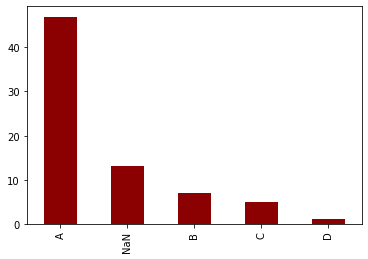

In [55]:
counts_model.plot(kind='bar', color='darkred')

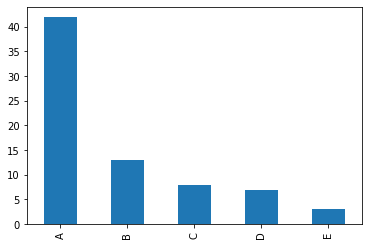

In [56]:
counts_test.plot(kind='bar')

Mildly comparable result already.

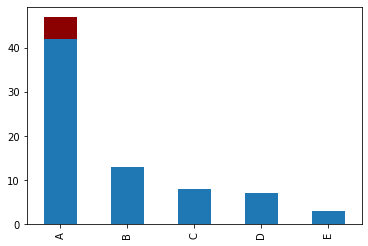

In [57]:
%matplotlib inline
counts_model.plot(kind='bar', color='darkred')
counts_test.plot(kind='bar')

> Overlayed predicted and actual grades in one convenient plot

# Quick analysis of the generated random forest classifier model

- Initial accuracy score was relatively low, over different features.
- The model did predict most of the grades and they do lineup quite well with the final grades.
- For whatever reason, it could not decide on a few grades... these are the 'NaN' values
- highly likely the current model is biased as there are 46% A grades in the dataset
- one option to improve this model is to make the dataset balanced

> but we need to build a model that uses data available at the start of a semester to predict if a student is struggling

That means we need activity profiles...

Additionally, at this checkpoint a cross-validation **sanity check** is mandatory.

# current findings?

- [x] early semester homework and test totals can be used to predict final grades


- [x] this prediction is biased on what we built the model with


- [x] this supports the notion we have a bad model on our hands


> FINAL GRADE = Homework & Test Scores + 2 Exam Scores + Project Score + Final Exam Score

> early semester homework & test scores therefore account for 20% of the final grade at most...

### another clue suggesting activity profiling is necessary 
### to compensate the lacking, imbalanced, biased, dynamic feature set!


# Cross-validation

- Need to confirm success of generated model.
- Cross-validation is ideal in this case.
- Given the size of the gradebook, capping at ~390 rows, splitting the training data 5 fold makes sense.
- Accuracy is to be calculated for each fold.
- The success accuracy for our model is the computed as the mean of the accuracies of each of the folds...

For this model to be successful, it should yield more than 80% accuracy.

EDIT: the model was not successful at a miserable 50% accuracy with the preliminary feature set :(

[Kfold cross validation (machinelearningmastery.com)](https://machinelearningmastery.com/k-fold-cross-validation/)

[Kfold cross validation explained (towardsdatascience.com)](https://towardsdatascience.com/k-fold-cross-validation-explained-in-plain-english-659e33c0bc0)

[kFold cross validation example (vitalflux.com)](https://vitalflux.com/k-fold-cross-validation-python-example/)

[cross validation, how to do it right (neptune.ai)](https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right)

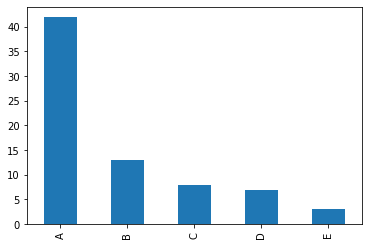

In [58]:
counts_test = y_test['Grade (letter)'].value_counts()
counts_test.plot(kind='bar')

In [59]:
# kFold cross validate

kf = KFold(n_splits=5)

kf.get_n_splits(X_train)


# iterate thru train and val and use splut on train...
accuracies = []
for train_index, val_index in kf.split(X_train):
    # save iloc for train, val in train & val crossval
    X_trainCrossVal, X_valCrossVal = X_train.iloc[train_index], X_train.iloc[val_index]
    
    # same for y train, val
    y_trainCrossVal, y_valCrossVal = y_train_dummies.iloc[train_index], y_train_dummies.iloc[val_index]
    
    # use X, y train crossval applied to same model as before
    rfc.fit(X_trainCrossVal, y_trainCrossVal)
    
    # calc accuracy score with predictor on x val
    acc = accuracy_score(y_valCrossVal, rfc.predict(X_valCrossVal))
    
    # append all accuracy scores
    accuracies.append(acc)

# plot scores + mean of accuracy scores...
print(f"Ran kFold with these settings: \n\n{kf}\nkFold accuracies: \n\n{accuracies} \n Average accuracy: \n\n{np.mean(accuracies)}")

Ran kFold with these settings: 

KFold(n_splits=5, random_state=None, shuffle=False)
kFold accuracies: 

[0.45454545454545453, 0.45454545454545453, 0.5227272727272727, 0.3409090909090909, 0.37209302325581395] 
 Average accuracy: 

0.42896405919661723


Average accuracy score for the model based on cross-validation is around 50%. 

Based on this, our generated RFC model's accuracy seems to be calculated correctly...

# Quick analysis of model (take 2)

- low accuracy could be attributable not only to a biased dataset, but also to this:

> we tried to calculate accuracy of a model using 20% of the final grade

## Let's add activity data into the mix

# headache incoming...


# Third Goal:
### discover common activity patterns of the students and create profiles of typical students using activity logs

##### table shown here is the result of our attempt to isolate a few students to understand better the log file structure in order to then extract student activity patterns

# let's automate this processing...

1. problems... need to replace student names with indexi in case their names are encountered
so need to load up students key and compare values...
... if value encountered, swap full name with index from students where that name is found...

2. pseudo code idea:

>iterate rows in student key dataframe...
for each first name, last name ==> merge to new temp dataframe and add that rows index
name new dataframe columns full name, index

then

>iterate rows in logbook:
if in row, column 'User's full name' user's full name found in student key
insert that row to 'student name (index later)' new dataframe...

>once done iterating and all rows copied to this student's dataframe...
save this dataframe as student name (index later).csv file in a separate path
or just use it in further processing

3. further processing?
look at Time column

- extract behaviour for 1st 6 weeks
- plot behaviour as days of week, activity count/frequency for that day
- add to plot deadline date for each week
- ensure each week separate plot or merged in a sensible manner or
- compute average of activity through all weeks of activity

4. the ideal result for just a few students would be to visualize activity patterns on a weekly basis

this could showcase differences in how different students tackle assignments


In [60]:
logbook_Inf_02 = pd.read_csv("ENlogs_LTAT.03.001_20210207-0942_Inf_02EN.csv") # naming convention: logbook_Uld_02
logbook_Inf_02.columns.values

array(['Unnamed: 0', 'Time ', "User's full name ", 'Affected user ',
       'Event context ', 'Component ', 'Name of event ', 'Description ',
       'Origin ', 'IP address '], dtype=object)

- [x] confirm log file structure survived translation

In [62]:
students_temp = students.copy()
logbook_Inf_02_temp = logbook_Inf_02.copy()


- [x] save time by developing on dataframe copies that dont have to be re-read every 2 mins...


- [x] combine two dataframe columns with strings in them [how to combine two pandas dataframe columns containing strings](https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-pandas-dataframe)

In [63]:
students_temp["User's full name "] = students_temp[['First name ', 'Last name ']].agg(' '.join, axis=1)
#students_temp

- [x] [pandas name dataframe with local variables?](https://stackoverflow.com/questions/40482738/how-to-name-dataframe-with-variables-in-pandas)


> considered iterating and renaming variables [python locals fcn usage examples](https://www.geeksforgeeks.org/python-locals-function/)

- [x] did not run with stupid idea above

In [67]:
test_207 = pd.DataFrame(columns = logbook_Inf_02_temp.columns.values)
student_index = 207

for log_entry in range(0, len(logbook_Inf_02_temp)):

    if logbook_Inf_02_temp["User's full name "].loc[log_entry] == students_temp["User's full name "].loc[student_index]:
        logbook_Inf_02_temp["User's full name "].loc[log_entry] = student_index
        
        if logbook_Inf_02_temp['Affected user '].loc[log_entry] == students_temp["User's full name "].loc[student_index]:
            logbook_Inf_02_temp['Affected user '].loc[log_entry] = student_index
        
        elif (logbook_Inf_02_temp['Affected user '].loc[log_entry] != students_temp["User's full name "].loc[student_index]) and (logbook_Inf_02_temp['Affected user '].loc[log_entry] != '-'):
            logbook_Inf_02_temp['Affected user '].loc[log_entry] = 'X'
    
        test_207 = test_207.append(logbook_Inf_02_temp.loc[log_entry])

len(test_207)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


2337

- [x] that works... wow

In [ ]:
test_207['Day of Week'] = pd.to_datetime(test_207['Time ']).dt.day_name()

- [x] figure out pandas datetime **black magic**

In [71]:
test_207['Day of Week'].value_counts()

Thursday     874
Wednesday    514
Friday       265
Tuesday      258
Monday       238
Saturday     124
Sunday        64
Name: Day of Week, dtype: int64

- [x] understood and acquired activity info

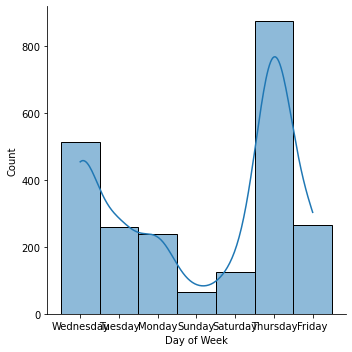

In [72]:
ax = sns.displot(test_207, x = 'Day of Week', kde = True)

- [x] plotted activity info but... its gibberish without categorical sorting of days in a week

In [73]:
logbook_AT_02 = pd.read_csv("ENlogs_LTAT.03.001_20210207-0937_AT_02_veebirühmEN.csv") # naming convention: logbook_Uld_02
logbook_AT_02_temp = logbook_AT_02.copy()

In [75]:
test_282 = pd.DataFrame(columns = logbook_AT_02_temp.columns.values)
student_index = 282

for log_entry in range(0, len(logbook_AT_02)):

    if logbook_AT_02_temp["User's full name "].loc[log_entry] == students_temp["User's full name "].loc[student_index]:
        logbook_AT_02_temp["User's full name "].loc[log_entry] = student_index
        
        if logbook_AT_02_temp['Affected user '].loc[log_entry] == students_temp["User's full name "].loc[student_index]:
            logbook_AT_02_temp['Affected user '].loc[log_entry] = student_index
        
        elif (logbook_AT_02_temp['Affected user '].loc[log_entry] != students_temp["User's full name "].loc[student_index]) and (logbook_AT_02_temp['Affected user '].loc[log_entry] != '-'):
            logbook_AT_02_temp['Affected user '].loc[log_entry] = 'X'
    
        test_282 = test_282.append(logbook_AT_02_temp.loc[log_entry])

len(test_282)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


2214

- [x] successdfully extracted activity profile for one student

In [76]:
test_282['Day of Week'] = pd.to_datetime(test_282['Time ']).dt.day_name()
#test_282['Day of Week'] = test_282['Day of Week'].sort_values()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

test_282['Day of Week'] = test_282['Day of Week'].astype(cat_type)
test_207['Day of Week'] = test_207['Day of Week'].astype(cat_type)

#test_282['Day of Week'] = test_282['Day of Week'].astype('category', categories=cats, ordered=True)

#test_282 = test_282.groupby(['Day of Week']).sum().reindex(cats) 


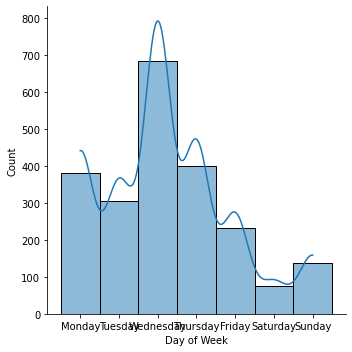

In [77]:
ax = sns.displot(test_282, x = 'Day of Week', kde = True)

- [x] successfully plotted activity profile for one student

Text(0.5, 1.0, 'A student')

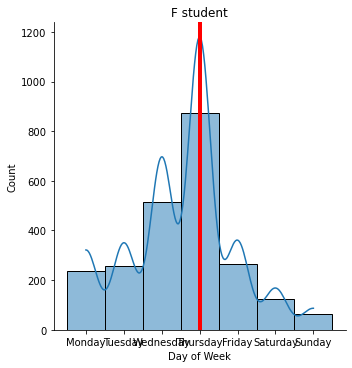

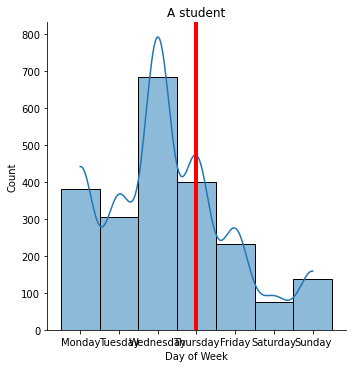

In [78]:
%matplotlib inline

sns.displot(test_207, x = 'Day of Week', kde = True)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title("F student")

sns.displot(test_282, x = 'Day of Week', kde = True)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title("A student")


# how to get student activity profile... but for all students...

Development & testing section.

In [79]:
df = pd.read_csv("ENlogs_LTAT.03.001_20210207-0937_AT_02_veebirühmEN.csv") # naming convention: logbook_Uld_02
df.drop(columns=['Unnamed: 0'], inplace=True)
df_temp = df.copy()

#students_df = pd.read_csv('FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv')

students_df_temp = students_filtered.copy()

students_df_temp["User's full name "] = students_df_temp[['First name ', 'Last name ']].agg(' '.join, axis=1)

index = students_df_temp['index '].loc[students_df_temp["User's full name "] == 'Tanel Tark'] # returns index of student full name


In [80]:
# process student activity out of logbook then compute days of the week
# save to new column and categorically sort days of the week

df_282 = pd.DataFrame(columns = df_temp.columns.values)
student_index = 282

for log_entry in range(0, len(df_temp)):

    if df_temp["User's full name "].loc[log_entry] == students_df_temp["User's full name "].loc[student_index]:
        df_temp["User's full name "].loc[log_entry] = student_index
        
        if df_temp['Affected user '].loc[log_entry] == students_df_temp["User's full name "].loc[student_index]:
            df_temp['Affected user '].loc[log_entry] = student_index
        
        elif (df_temp['Affected user '].loc[log_entry] != students_temp["User's full name "].loc[student_index]) and (df_temp['Affected user '].loc[log_entry] != '-'):
            df_temp['Affected user '].loc[log_entry] = 'X'
    
        df_282 = df_282.append(df_temp.loc[log_entry])


In [81]:
df_282_temp = df_282.copy()

In [82]:
df_282_temp['Day of Week'] = pd.to_datetime(df_282_temp['Time ']).dt.day_name()

df_282_temp['Time '] = pd.to_datetime(df_282_temp['Time '], format="%d.%m.%Y %H:%M:%S")

#df_282_temp['Time '] = pd.to_datetime(df_282_temp['Time '])

df_282_temp = df_282_temp.reset_index()

#df_282_temp = df_282_temp.set_index(['Time '])

In [83]:
df_282_temp['Month'] = df_282_temp['Time '].dt.month

- [x] [working with datetime was hard](https://towardsdatascience.com/working-with-datetime-in-pandas-dataframe-663f7af6c587)

In [84]:
df_282_check = df_282_temp.loc[(df_282_temp['Month'] > 8) & (df_282_temp['Month'] < 11)].copy()

# solution to extracting early activity data was to select the month of septembre and october! 

In [85]:

end_date = '2020-09-01'

start_date = '2020-11-01'

#df_282_check = df_282_temp.loc[start_date:end_date]

df_282_check['Day of Week'].value_counts()

Monday       352
Wednesday    316
Tuesday      222
Friday       201
Thursday     178
Sunday       115
Saturday       1
Name: Day of Week, dtype: int64

- [x] sanity checked (yes, checked sanity) its 5AM

In [86]:
#df_282['Day of Week'] = pd.to_datetime(df_282['Time ']).dt.day_name()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)

df_282_check['Day of Week'] = df_282_check['Day of Week'].astype(cat_type)
df_282_temp['Day of Week'] = df_282_temp['Day of Week'].astype(cat_type)

- [x] categorical encoding tested again on new month selector - working A-OK

Text(0.5, 1.0, 'A-student throughout the semester')

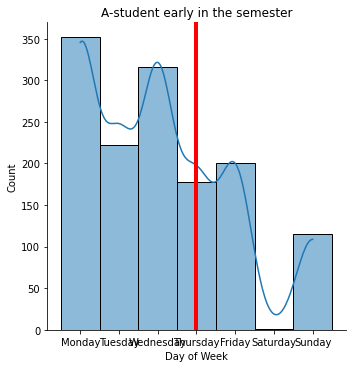

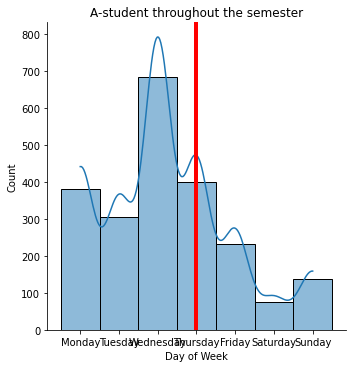

In [87]:
%matplotlib inline
student_grade = students_df_temp['Grade (letter)'].loc[index].values[0]
title_text = student_grade + "-student"

# plot activity profile, set student title to grade student
sns.displot(df_282_check, x = 'Day of Week', kde = True)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title(title_text+" early in the semester")

sns.displot(df_282_temp, x = 'Day of Week', kde = True)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title(title_text+" throughout the semester")


### Concentrator segment: GOAL 2

- compile dataframe for model from goal 2
- have current and new features
- new features are: activity count per day
- activity profile is sliced from early activity

- [x] fat function below is student activity processor stack, developed above

In [379]:

def process_student_activity(csv_activity_log_file, index_of_student, plot_activity, returnvalcount):

    df = pd.read_csv(csv_activity_log_file) # naming convention: logbook_Uld_02

    #df = pd.read_csv("ENlogs_LTAT.03.001_20210207-0937_AT_02_veebirühmEN.csv") # naming convention: logbook_Uld_02
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df_temp = df.copy()

    students_df = pd.read_csv('FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv')
    students_df.drop(columns=['Unnamed: 0'], inplace=True)
    students_df_temp = students_df.copy()

    students_df_temp["User's full name "] = students_df_temp[['First name ', 'Last name ']].agg(' '.join, axis=1)
    
    # correct student index mismatch in filtered student key dataset
    index = students_df_temp['index '].loc[students_df_temp['index '] == index_of_student]
    student_index = students_df_temp["User's full name "].loc[students_df_temp['index '] == index_of_student].index.values[0]
    # student_index stores the index position where this students name is...

    student_grade = students_df_temp['Grade (letter)'].loc[students_df_temp['index '] == index_of_student].values[0]
    print(f"Processing student with grade: {student_grade} and index: {student_index}", end="\r")
    df_282 = pd.DataFrame(columns = df_temp.columns.values)

    for log_entry in range(0, len(df_temp)):
        
        if df_temp["User's full name "].loc[log_entry] == students_df_temp["User's full name "].loc[student_index]:
            df_temp["User's full name "].loc[log_entry] = student_index

            if df_temp['Affected user '].loc[log_entry] == students_df_temp["User's full name "].loc[student_index]:
                df_temp['Affected user '].loc[log_entry] = student_index

            elif (df_temp['Affected user '].loc[log_entry] != students_df_temp["User's full name "].loc[student_index]) and (df_temp['Affected user '].loc[log_entry] != '-'):
                df_temp['Affected user '].loc[log_entry] = 'X'

            df_282 = df_282.append(df_temp.loc[log_entry])

    #print(f"Done processing student {index_of_student}!", end="\r")
    
    df_282_temp = df_282.copy()

    df_282_temp['Day of Week'] = pd.to_datetime(df_282_temp['Time ']).dt.day_name()

    # save to new column and categorically sort days of the week, find month number and store in new column

    df_282_temp['Time '] = pd.to_datetime(df_282_temp['Time '], format="%d.%m.%Y %H:%M:%S")
    df_282_temp = df_282_temp.reset_index()
    df_282_temp['Month'] = df_282_temp['Time '].dt.month

    df_282_check = df_282_temp.loc[(df_282_temp['Month'] > 8) & (df_282_temp['Month'] < 11)].copy()

    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat_type = CategoricalDtype(categories=cats, ordered=True)
    df_282_check['Day of Week'] = df_282_check['Day of Week'].astype(cat_type)
    df_282_temp['Day of Week'] = df_282_temp['Day of Week'].astype(cat_type)

    if plot_activity == True:
        # plot activity profile, set student title to grade student
        title_text = student_grade + "-student"

        sns.displot(df_282_check, x = 'Day of Week', kde = True)
        plt.gcf().set_size_inches(12, 8)
        plt.axvline(x='Thursday', color='red', linewidth=4)
        plt.title(title_text+" early in the semester", loc='left', fontweight='bold', fontsize=16)
        
        sns.displot(df_282_temp, x = 'Day of Week', kde = True)
        plt.gcf().set_size_inches(12, 8)
        plt.axvline(x='Thursday', color='red', linewidth=4)
        plt.title(title_text+" throughout the semester", loc='left', fontweight='bold', fontsize=16)
    
    if returnvalcount == True:
        activity_count_day_of_week_whole_semester = df_282_temp['Day of Week'].value_counts()
        activity_count_day_of_week_start_of_semester = df_282_check['Day of Week'].value_counts()
        return activity_count_day_of_week_whole_semester, activity_count_day_of_week_start_of_semester, student_grade
    
    return df_282_temp, df_282_check, student_grade

- [x] it comes with a neat function call! we like fancy features here :)

In [89]:
file_csv = "ENlogs_LTAT.03.001_20210207-0937_AT_02_veebirühmEN.csv"
wh_sem, st_sem, st_grade = process_student_activity(csv_activity_log_file = file_csv, index_of_student = 282, plot_activity=False, returnvalcount=False)

Student grade sanity check: A
Student Index sanity check: 241

Done processing student 282!


In [90]:
# to get dataframes out of the value counts, use this solution below:
st_sem_df = pd.DataFrame(st_sem).reset_index()
st_sem_df.rename({'index':'Day of week', 'Day of Week':'Count'}, axis = 'columns', inplace=True)

wh_sem_df = pd.DataFrame(wh_sem).reset_index()
wh_sem_df.rename({'index':'Day of week', 'Day of Week':'Count'}, axis = 'columns', inplace=True)


- [x] yes, there's a "catplot" in seaborn

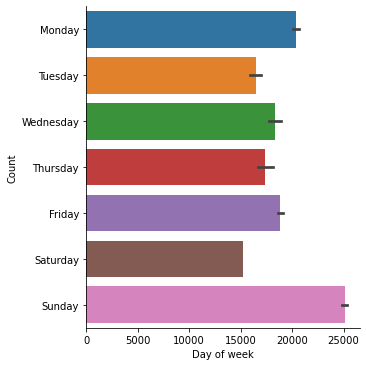

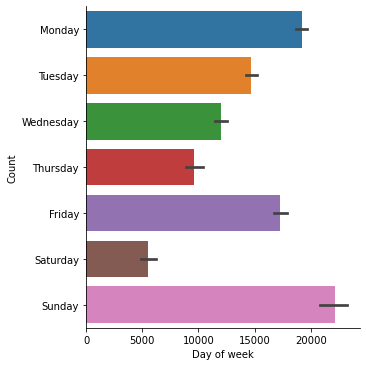

In [91]:
# can plot from value counts
sns.catplot(x='Day of week', y='Count', data=st_sem_df, kind='bar')
sns.catplot(x='Day of week', y='Count', data=wh_sem_df, kind='bar')


In [93]:
# can plot from value counts
'''
labels = st_sem_df['Day of week'].values
st_sem_count = st_sem_df['Count']
wh_sem_count = wh_sem_df['Count']

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, st_sem_count, width, label='Start of Semester')
rects2 = ax.bar(x + width/2, wh_sem_count, width, label='Throughout Semester')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Activity Count')
ax.set_xlabel('Day of the Week')
ax.set_title(st_grade+"-student activity profile")
ax.set_xticks(x, labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

plt.figure(figsize =(12, 10))
fig.tight_layout()

plt.show()
'''
print("skip")

skip


In [ ]:
# can plot from value counts
'''
fig = plt.figure(figsize =(8, 7))
plt.bar(st_sem_df['Day of week'], st_sem_df['Count'], color='red')
plt.title(st_grade+"-student early in the semester")

fig = plt.figure(figsize =(8, 7))
plt.bar(wh_sem_df['Day of week'], wh_sem_df['Count'], color='orange')
plt.title(st_grade+"-student throughout the semester")
plt.show()
'''
print("was testing plotting from value counts")

- [x] plt.gcf().set_size_inches(15, 8) < this right here makes the plot bigger (and actually works with sns)


- [x] could also use %matplotlib widget but then plotting behaviour is even more messy...

Text(0.5, 1.0, 'A-student throughout the semester')

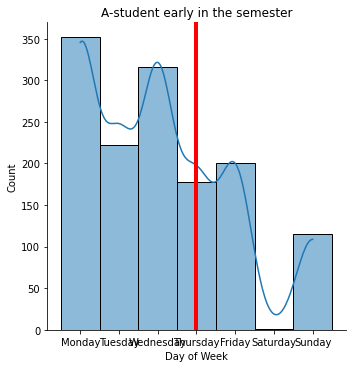

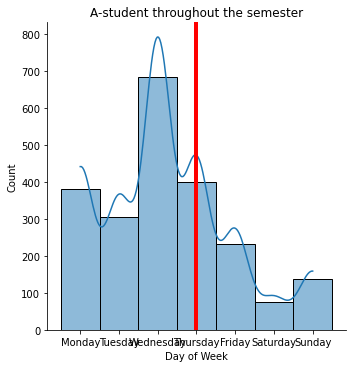

In [95]:
sns.displot(st_sem, x='Day of Week', kde = True)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title(st_grade+"-student early in the semester")
plt.gcf().set_size_inches(15, 8)
sns.displot(wh_sem, x='Day of Week', kde = True)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title(st_grade+"-student throughout the semester")
plt.gcf().set_size_inches(15, 8)

## We can access activity profile of one student, let's gather these profiles on the rest

# but we need a map of which log file belongs to which student...

# then we need to get the activity profile for each student by calling this map

- [x] oversize the todo text @5AM

In [143]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
########################
#pd.set_option('display.max_colwidth', -1)

- [x] reset display options just in case

In [144]:
# iterate all students

students_df = pd.read_csv('FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv')

students_df.drop(columns=['Unnamed: 0'], inplace=True)

students_df["User's full name "] = students_df[['First name ', 'Last name ']].agg(' '.join, axis=1)

all_the_students = students_df['index '].values


- [x] get list of all the students

In [145]:
# get the relevant filenames
cwd = os.getcwd()
onlyfiles = [os.path.join(cwd, f) for f in os.listdir(cwd) if 
os.path.isfile(os.path.join(cwd, f))]

log_files = []
for file in onlyfiles:
    if os.path.basename(file).startswith("EN"):
        log_files.append(os.path.basename(file))

print(log_files)

['ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv', 'ENlogs_LTAT.03.001_20210207-0937_AT_02_veebirühmEN.csv', 'ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv', 'ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv', 'ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv', 'ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv', 'ENlogs_LTAT.03.001_20210207-0940_Inf_01EN.csv', 'ENlogs_LTAT.03.001_20210207-0942_Inf_02EN.csv', 'ENlogs_LTAT.03.001_20210207-0942_Inf_03EN.csv', 'ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebirühmEN.csv', 'ENlogs_LTAT.03.001_20210207-0943_Inf_05EN.csv', 'ENlogs_LTAT.03.001_20210207-0943_Inf_06EN.csv', 'ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv', 'ENlogs_LTAT.03.001_20210207-0945_Inf_08EN.csv']


- [x] get list of all the files

In [159]:

def get_log_file_for_student(student_index_iterand, log_files):
    students_df = pd.read_csv('FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv')

    students_df.drop(columns=['Unnamed: 0'], inplace=True)

    students_df["User's full name "] = students_df[['First name ', 'Last name ']].agg(' '.join, axis=1)

    # return student index in dataframe
    student_index = students_df["User's full name "].loc[students_df['index '] == student_index_iterand].index.values[0]
    
    # iterate all log files
    for log_file in log_files:
        
        # load each log file on its own once 
        logbook_df = pd.read_csv(log_file)
        
        count = 0 # count how often student in logfile       
        for row in range(0, len(logbook_df)):
            if logbook_df["User's full name "].loc[row] == students_df["User's full name "].loc[student_index]:
                count+=1
            if count > 1000: # if student name more than 1k times in this file, return this file and stop
                return log_file


- [x] make crazy function, totally not multithreadable operation

> modus operandi:
1. load log file as dataframe
2. check in log file value_counts for current student
3. if over threshold ~1000
4. stop and return filename

[learned a new trick: use end="\r" to print over same line in python](https://www.kite.com/python/answers/how-to-print-over-the-same-line-in-python#:~:text=Use%20a%20carriage%20return%20%22%5Cr,the%20following%20print()%20statement.)

# DO NOT RERUN LINES BELOW

it takes forever...



In [147]:
'''
def map_students_to_log_files(mapped):
    print(mapped)
    students_df = pd.read_csv('FILTERED_Students_Name_Surname_ID_email_indexIDkey.csv')
    all_the_students = students_df['index '].values
    
    if mapped == 1:
        student_iterator = all_the_students[0:36]
    elif mapped == 2:
        student_iterator = all_the_students[36:72]
    elif mapped == 3:
        student_iterator = all_the_students[72:108]
    elif mapped == 4:
        student_iterator = all_the_students[108:144]
    elif mapped == 5:
        student_iterator = all_the_students[144:180]
    elif mapped == 6:
        student_iterator = all_the_students[180:216]
    elif mapped == 7:
        student_iterator = all_the_students[216:252]
    elif mapped == 8:
        student_iterator = all_the_students[252:]

    cwd = os.getcwd()
    onlyfiles = [os.path.join(cwd, f) for f in os.listdir(cwd) if 
    os.path.isfile(os.path.join(cwd, f))]

    log_files = []
    for file in onlyfiles:
        if os.path.basename(file).startswith("EN"):
            log_files.append(os.path.basename(file))
    
    student_log_map_df = pd.DataFrame(columns=['Student index', 'Log File'])
    #student_log_map_dict = {
    #    0: 'ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv'    
    #}

    start = time.time()
    i=0
    for student_index_iterand in student_iterator:
        i+=1
        print(f"\nProcessing student {student_index_iterand} to log mapping {round(((i)/len(all_the_students))*100, 2)}% complete. Been working for: {round((time.time() - start)/60)} minutes...\n", end="\r")
        
        logFile = get_log_file_for_student(student_index_iterand, log_files)
        
        #student_log_map_dict[student_index_iterand] = logFile
        student_log_map_df = student_log_map_df.append({'Student index': student_index_iterand, 'Log File': logFile}, ignore_index=True)

    end = time.time()
    print(f"\nAll done! ... and it only took {round((end - start)/60)} minutes...")
    #student_log_map_df.to_csv("STUDENT_TO_LOG_MAP_KEY.csv")
    
    #return student_log_map_df, student_log_map_dict
    return student_log_map_df
'''
print("what could possibly go wrong")

what could possibly go wrong


In [148]:

'''
pool = ThreadPool(16) # Threads

time1 = time.time()

st1 = 1
st2 = 2
st3 = 3
st4 = 4
st5 = 5
st6 = 6
st7 = 7
st8 = 8

try:
    
    print("about to start multithreading...")
    
    student_log_map_df1 = pool.map(map_students_to_log_files(st1))
    
    student_log_map_df2 = pool.map(map_students_to_log_files(st2))
    
    student_log_map_df3 = pool.map(map_students_to_log_files(st3))
    
    student_log_map_df4 = pool.map(map_students_to_log_files(st4))
    
    student_log_map_df5 = pool.map(map_students_to_log_files(st5))
    
    student_log_map_df6 = pool.map(map_students_to_log_files(st6))
    
    student_log_map_df7 = pool.map(map_students_to_log_files(st7))
    
    student_log_map_df8 = pool.map(map_students_to_log_files(st8))
    
    print("what is going on...")

except Exception as e:
    raise e

finally:
    pool.close()
    pool.join()
    student_log_map_df = student_log_map_df1.append(student_log_map_df2).append(student_log_map_df3).append(student_log_map_df4).append(student_log_map_df5).append(student_log_map_df6).append(student_log_map_df7).append(student_log_map_df8)
    student_log_map_df.to_csv("STUDENT_TO_LOG_MAP_KEY.csv")

time2 = time.time()
print(f"Multithreaded mapping of {len(all_the_students)} took {round((time2 - time1)/60)} minutes")
'''
print("multithreading failed")

multithreading failed


In [160]:
'''
student_log_map_df = pd.DataFrame(columns=['Student index', 'Log File'])
student_log_map_dict = {
    0: 'ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv'    
}

start = time.time()
i=0
for student_index_iterand in all_the_students:
    i+=1
    print(f"Processing student {student_index_iterand} to log mapping {round(((i)/len(all_the_students))*100, 2)}% complete. Been working for: {round((time.time() - start)/60)} minutes...", end="\r")
    
    logFile = get_log_file_for_student(student_index_iterand, log_files)
    
    student_log_map_dict[student_index_iterand] = logFile
    student_log_map_df = student_log_map_df.append({'Student index': student_index_iterand, 'Log File': logFile}, ignore_index=True)

end = time.time()
print(f"All done! ... and it only took {round((end - start)/60)} minutes...")
student_log_map_df.to_csv("STUDENT_TO_LOG_MAP_KEY.csv")
'''
print("run this to map students to log files CAUTION: not multithreaded, takes about an hour!")

run this to map students to log files CAUTION: not multithreaded, takes about an hour!


- [x] map students to log files

In [161]:
student_log_map_df

,Student index,Log File
0,0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv
1,1,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv
2,2,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv
3,3,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv
4,5,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...
...,...,...
288,337.0,NaN
289,338,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv
290,339.0,NaN
291,340,ENlogs_LTAT.03.001_20210207-0940_Inf_01EN.csv


In [158]:
for key in student_log_map_dict.keys():
    print(student_log_map_dict[key], key)

ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv 0
ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv 1
ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv 2
ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv 3
ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebirühmEN.csv 5
None 6
ENlogs_LTAT.03.001_20210207-0943_Inf_06EN.csv 8
None 9
None 11
ENlogs_LTAT.03.001_20210207-0940_Inf_01EN.csv 12
None 14
None 15
ENlogs_LTAT.03.001_20210207-0943_Inf_05EN.csv 16
None 17
ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv 18
ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv 19
ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv 20
None 21
ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebirühmEN.csv 23
ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv 24
None 25
ENlogs_LTAT.03.001_20210207-0943_Inf_05EN.csv 26
ENlogs_LTAT.03.001_20210207-0943_Inf_06EN.csv 27
ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv 28
None 29
ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebirühmEN.csv 30
None 32
None 33
ENlogs_LTAT.03.001_20210207-0942_Inf_02EN.csv 34
None 35
ENl

In [206]:
student_log_map = pd.read_csv("STUDENT_TO_LOG_MAP_KEY.csv")
student_log_map.drop(columns=['Unnamed: 0'], inplace=True)
student_log_map_temp = student_log_map.copy()

In [207]:
student_log_map_temp.columns
student_log_map_temp

,Student index,Log File
0,0.0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv
1,1.0,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv
2,2.0,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv
3,3.0,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv
4,5.0,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...
...,...,...
288,337.0,NaN
289,338.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv
290,339.0,NaN
291,340.0,ENlogs_LTAT.03.001_20210207-0940_Inf_01EN.csv


- [x] filter out all students who were not found in log files for some reason [help was found here](https://datatofish.com/rows-with-nan-pandas-dataframe/)

In [208]:
student_log_map_temp[student_log_map_temp['Log File'].isna()]

,Student index,Log File
5,6.0,NaN
7,9.0,NaN
8,11.0,NaN
10,14.0,NaN
11,15.0,NaN
...,...,...
285,333.0,NaN
286,334.0,NaN
288,337.0,NaN
290,339.0,NaN


> how many students were not that active on Moodle?

In [209]:

len(student_log_map_temp[student_log_map_temp['Log File'].isna()])

160

In [211]:
student_log_map_temp.dropna(inplace=True)
print("removed all empty rows...")

removed all empty rows...


In [223]:
valid_student_indexes = student_log_map_temp['Student index'].values
valid_student_indexes

array([  0.,   1.,   2.,   3.,   5.,   8.,  12.,  16.,  18.,  19.,  20.,
        23.,  24.,  26.,  27.,  28.,  30.,  34.,  38.,  39.,  40.,  41.,
        47.,  48.,  50.,  51.,  52.,  58.,  59.,  60.,  63.,  65.,  67.,
        69.,  70.,  72.,  73.,  75.,  77.,  78.,  82.,  83.,  86.,  91.,
        93.,  95., 100., 102., 104., 108., 113., 115., 117., 118., 123.,
       124., 127., 128., 129., 134., 135., 136., 139., 140., 141., 142.,
       145., 146., 149., 153., 157., 164., 166., 170., 171., 175., 177.,
       184., 187., 190., 191., 196., 202., 203., 206., 207., 208., 209.,
       211., 214., 217., 218., 219., 223., 227., 228., 239., 241., 242.,
       243., 246., 248., 249., 251., 252., 260., 263., 264., 266., 268.,
       270., 271., 277., 281., 282., 283., 285., 287., 291., 294., 295.,
       296., 298., 301., 316., 317., 323., 325., 331., 332., 335., 338.,
       340.])

In [252]:
student_log_map_temp = student_log_map_temp.reset_index()
student_log_map_temp

,index,Student index,Log File
0,0,0.0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv
1,1,1.0,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv
2,2,2.0,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv
3,3,3.0,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv
4,4,5.0,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...
...,...,...,...
128,283,331.0,ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv
129,284,332.0,ENlogs_LTAT.03.001_20210207-0942_Inf_03EN.csv
130,287,335.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv
131,289,338.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv


# Half of the students were not very active on Moodle...

### unlike the few test students subjects we selected previously...

- next... iterate for all students and save activity profiles to new dataframe

In [234]:
# dataframe to store student activity profiles for the start of the semester
student_activity_profiles_start_sem_df = pd.DataFrame(columns=['Student index',
                                                               'Log File',
                                                               'Grade',
                                                               'Monday',
                                                               'Tuesday',
                                                               'Wednesday',
                                                               'Thursday',
                                                               'Friday',
                                                               'Saturday',
                                                               'Sunday'])

# dataframe to store student activity profiles for the whole semester
student_activity_profiles_all_sem_df = pd.DataFrame(columns=['Student index',
                                                             'Log File',
                                                             'Grade',
                                                             'Monday',
                                                             'Tuesday',
                                                             'Wednesday',
                                                             'Thursday',
                                                             'Friday',
                                                             'Saturday',
                                                             'Sunday'])

- [x] prepare wrapper for model fodder

In [253]:
#for i in range(0, 3):
start = time.time()
for i in range(0, len(student_log_map_temp)):
    
    print(f"Extracting activity profile of student {i} Processing {round(((i)/len(student_log_map_temp))*100, 2)}% complete.")
    print("\n")
    student_indx = student_log_map_temp['Student index'].loc[i]
    file_csv = student_log_map_temp['Log File'].loc[i]
    
    wh_sem, st_sem, st_grade = process_student_activity(csv_activity_log_file = file_csv,
                                                        index_of_student = student_indx,
                                                        plot_activity=False,
                                                        returnvalcount=True)
    
    # to get dataframes out of the value counts, use this solution below:
    st_sem_df = pd.DataFrame(st_sem).reset_index()
    st_sem_df.rename({'index':'Day of week', 'Day of Week':'Count'}, axis = 'columns', inplace=True)

    wh_sem_df = pd.DataFrame(wh_sem).reset_index()
    wh_sem_df.rename({'index':'Day of week', 'Day of Week':'Count'}, axis = 'columns', inplace=True)
    
    st_sem_row = {
        'Student index': student_indx,
        'Log File': file_csv,
        'Grade': st_grade,
        'Monday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Monday'].values[0],
        'Tuesday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Tuesday'].values[0],
        'Wednesday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Wednesday'].values[0],
        'Thursday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Thursday'].values[0],
        'Friday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Friday'].values[0],
        'Saturday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Saturday'].values[0],
        'Sunday': st_sem_df['Count'].loc[st_sem_df['Day of week'] == 'Sunday'].values[0]
    }
    
    wh_sem_row = {
        'Student index': student_indx,
        'Log File': file_csv,
        'Grade': st_grade,
        'Monday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Monday'].values[0],
        'Tuesday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Tuesday'].values[0],
        'Wednesday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Wednesday'].values[0],
        'Thursday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Thursday'].values[0],
        'Friday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Friday'].values[0],
        'Saturday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Saturday'].values[0],
        'Sunday': wh_sem_df['Count'].loc[wh_sem_df['Day of week'] == 'Sunday'].values[0]
    }
    #print(wh_sem_row)
    
    student_activity_profiles_start_sem_df = student_activity_profiles_start_sem_df.append(st_sem_row, ignore_index=True)
    
    student_activity_profiles_all_sem_df = student_activity_profiles_all_sem_df.append(wh_sem_row, ignore_index=True)

end = time.time()
print(f"\n\nAll done! ... and it only took {round((end - start)/60)} minutes...")
student_activity_profiles_start_sem_df.to_csv("STUDENT_ACTIVITY_PROFILES_START_OF_SEMESTER.csv")
student_activity_profiles_all_sem_df.to_csv("STUDENT_ACTIVITY_PROFILES_ALL_SEMESTER.csv")

Extracting activity profile of student 0 Processing 0.0% complete.

Extracting activity profile of student 1 Processing 0.34% complete.

Extracting activity profile of student 2 Processing 0.68% complete.

Extracting activity profile of student 3 Processing 1.02% complete.

Extracting activity profile of student 4 Processing 1.37% complete.

Extracting activity profile of student 5 Processing 1.71% complete.

Extracting activity profile of student 6 Processing 2.05% complete.

Extracting activity profile of student 7 Processing 2.39% complete.

Extracting activity profile of student 8 Processing 2.73% complete.

Extracting activity profile of student 9 Processing 3.07% complete.

Extracting activity profile of student 10 Processing 3.41% complete.

Extracting activity profile of student 11 Processing 3.75% complete.

Extracting activity profile of student 12 Processing 4.1% complete.

Extracting activity profile of student 13 Processing 4.44% complete.

Extracting activity profile of s

Extracting activity profile of student 116 Processing 39.59% complete.

Extracting activity profile of student 117 Processing 39.93% complete.

Extracting activity profile of student 118 Processing 40.27% complete.

Extracting activity profile of student 119 Processing 40.61% complete.

Extracting activity profile of student 120 Processing 40.96% complete.

Extracting activity profile of student 121 Processing 41.3% complete.

Extracting activity profile of student 122 Processing 41.64% complete.

Extracting activity profile of student 123 Processing 41.98% complete.

Extracting activity profile of student 124 Processing 42.32% complete.

Extracting activity profile of student 125 Processing 42.66% complete.

Extracting activity profile of student 126 Processing 43.0% complete.

Extracting activity profile of student 127 Processing 43.34% complete.

Extracting activity profile of student 128 Processing 43.69% complete.

Extracting activity profile of student 129 Processing 44.03% compl

- [x] looks like the extraction mining went a bit awry, so drop duplicate rows...

In [292]:
student_activity_profiles_start_sem_df_temp = student_activity_profiles_start_sem_df.copy()

student_activity_profiles_start_sem_df_temp.drop_duplicates(subset ='Student index', keep = 'first', inplace = True)

,Student index,Log File,Grade,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv,A,137,64,260,136,197,513,120
1,1.0,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv,A,183,215,388,314,269,8,72
2,2.0,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv,A,123,178,1221,249,545,4,176
19,3.0,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv,C,229,263,242,494,258,1,93
20,5.0,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...,B,216,165,422,162,97,17,196
...,...,...,...,...,...,...,...,...,...,...
149,331.0,ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv,B,282,144,364,609,681,37,175
150,332.0,ENlogs_LTAT.03.001_20210207-0942_Inf_03EN.csv,B,205,476,746,281,89,94,45
151,335.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,C,121,71,482,560,229,12,118
152,338.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,A,122,242,427,269,136,3,29


In [291]:
student_activity_profiles_all_sem_df_temp = student_activity_profiles_all_sem_df.copy()

student_activity_profiles_all_sem_df_temp.drop_duplicates(subset ='Student index', keep = 'first', inplace = True)

,Student index,Log File,Grade,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv,A,156,110,724,377,239,632,168
1,1.0,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv,A,266,223,554,806,417,174,77
2,2.0,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv,A,293,186,1454,553,610,96,275
19,3.0,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv,C,470,284,453,830,400,162,236
20,5.0,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...,B,236,256,838,359,189,148,287
...,...,...,...,...,...,...,...,...,...,...
149,331.0,ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv,B,663,225,625,1163,811,111,210
150,332.0,ENlogs_LTAT.03.001_20210207-0942_Inf_03EN.csv,B,353,594,1305,506,136,169,218
151,335.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,C,254,131,656,904,240,201,251
152,338.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,A,234,253,610,545,183,168,145


- [x] extract student activity profiles and append them to separate dataframes (early semester vs whole semester comparison)

In [333]:
model_fodder = grades_en[['index ', 'Total video lectures (points) ', 'Homework Total (points) ', 'Total project (points) ', 'Total inspection work (points) ', 'Total exam (points) ', 'Additional points (points) ', 'Grade (points) ', 'Grade (letter)']].copy()


model_fodder.drop(labels=F_student, axis=0, inplace=True) # get rid of F student or do one hot encoding prior to split?


features = model_fodder[['Homework Total (points) ']]

features_kept = pd.DataFrame(columns=['Homework Total (points) '])
for index in valid_student_indexes:
    #print(int(index))
    if int(index) != 207:
        features_kept = features_kept.append(features.loc[int(index)])

labels = model_fodder[['Grade (letter)']]

labels_kept = pd.DataFrame(columns=['Grade (letter)'])
for index in valid_student_indexes:
    #print(int(index))
    if int(index) != 207:
        labels_kept = labels_kept.append(labels.loc[int(index)])
labels_kept
labels_kept = labels_kept.reset_index()
labels_kept = labels_kept.drop(['index'], axis = 1)
labels_kept.value_counts()

Grade (letter)
A                 77
B                 27
C                 15
D                  9
E                  4
dtype: int64

In [334]:
features_kept_temp = features_kept
features_kept_temp = features_kept_temp.reset_index()
features_kept_temp = features_kept_temp.drop(['index'], axis = 1)

activities_temp = student_activity_profiles_start_sem_df_temp[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

activities_temp = activities_temp.reset_index()
activities_temp = activities_temp.drop(['index'], axis = 1)
final_features = pd.concat([features_kept_temp, activities_temp], axis=1)
final_features = final_features.drop([132], axis = 0)
final_features

,Homework Total (points),Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,12.5,137,64,260,136,197,513,120
1,11.2,183,215,388,314,269,8,72
2,10.8,123,178,1221,249,545,4,176
3,11.4,229,263,242,494,258,1,93
4,12.8,216,165,422,162,97,17,196
...,...,...,...,...,...,...,...,...
127,8.7,286,159,183,388,248,163,65
128,12.8,282,144,364,609,681,37,175
129,7.8,205,476,746,281,89,94,45
130,12.2,121,71,482,560,229,12,118


In [335]:
labels = labels_kept
features = final_features

In [348]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.6, random_state=100)

y_train_dummies = pd.get_dummies(y_train, columns=['Grade (letter)']) # onehot encode train
y_test_dummies = pd.get_dummies(y_test, columns=['Grade (letter)']) # and test sets


In [349]:
y_train_dummies.head() # sanity check

,Grade (letter)_A,Grade (letter)_B,Grade (letter)_C,Grade (letter)_D,Grade (letter)_E
120,1,0,0,0,0
63,1,0,0,0,0
19,1,0,0,0,0
128,0,1,0,0,0
80,1,0,0,0,0


In [350]:
y_test_dummies.head() # sanity check

,Grade (letter)_A,Grade (letter)_B,Grade (letter)_C,Grade (letter)_D,Grade (letter)_E
28,0,1,0,0,0
131,0,1,0,0,0
45,1,0,0,0,0
73,1,0,0,0,0
33,1,0,0,0,0


In [353]:

print(f"Training RFC model with these features: \n\t{X_train.columns.values}")

rfc = RandomForestClassifier(n_estimators=6900, max_depth=420, random_state=42)
rfc.fit(X_train, y_train_dummies)


y_pred = rfc.predict(X_test)
#print(y_pred, y_test_dummies)
acc = accuracy_score(y_test_dummies, y_pred)
print(f"The models prediction is {round(acc*100, 8)}% accurate.")

predicted_grades = pd.DataFrame(y_pred, columns = y_test_dummies.columns.values)

predicted_grades.insert(len(predicted_grades.columns), 'Grade (letter)', (np.ones(len(predicted_grades))))
    
for column in predicted_grades.columns:
    for i in range(0, len(predicted_grades)):
        
        if predicted_grades[column].loc[i] == 1:
            
            if column == 'Grade (letter)_A':
                predicted_grades['Grade (letter)'].loc[i] = 'A'
            
            elif column == 'Grade (letter)_B':
                predicted_grades['Grade (letter)'].loc[i] = 'B'
            
            elif column == 'Grade (letter)_C':
                predicted_grades['Grade (letter)'].loc[i] = 'C'
            
            elif column == 'Grade (letter)_D':
                predicted_grades['Grade (letter)'].loc[i] = 'D'
            
            elif column == 'Grade (letter)_E':
                predicted_grades['Grade (letter)'].loc[i] = 'E'
            
            elif column == 'Grade (letter)_F':
                predicted_grades['Grade (letter)'].loc[i] = 'F'
            
            else:
                predicted_grades['Grade (letter)'].loc[i] = 'NaN'

y_test['Grade (letter)'].value_counts()
predicted_grades['Grade (letter)'].value_counts()
y_test_dummies.columns.values


Training RFC model with these features: 
	['Homework Total (points) ' 'Monday' 'Tuesday' 'Wednesday' 'Thursday'
 'Friday' 'Saturday' 'Sunday']
The models prediction is 46.25% accurate.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


array(['Grade (letter)_A', 'Grade (letter)_B', 'Grade (letter)_C',
       'Grade (letter)_D', 'Grade (letter)_E'], dtype=object)

In [354]:
counts_test = y_test['Grade (letter)'].value_counts()

counts_model = predicted_grades['Grade (letter)'].sort_values(ascending=False)
counts_model = counts_model.value_counts()


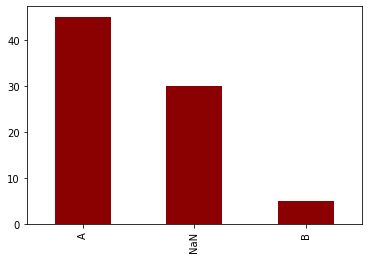

In [355]:
counts_model.plot(kind='bar', color='darkred')

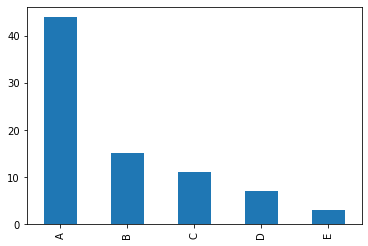

In [356]:
counts_test.plot(kind='bar')

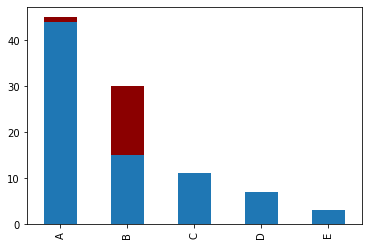

In [357]:
# plot findings
counts_model.plot(kind='bar', color='darkred')
counts_test.plot(kind='bar')

- [x] copy over model generator stack


- [x] regenerate model behaviour but add activity profile features now


- [x] compare model results


- [x] plot something

In [358]:
# kFold cross validate

kf = KFold(n_splits=5)

kf.get_n_splits(X_train)


# iterate thru train and val and use splut on train...
accuracies = []
for train_index, val_index in kf.split(X_train):
    # save iloc for train, val in train & val crossval
    X_trainCrossVal, X_valCrossVal = X_train.iloc[train_index], X_train.iloc[val_index]
    
    # same for y train, val
    y_trainCrossVal, y_valCrossVal = y_train_dummies.iloc[train_index], y_train_dummies.iloc[val_index]
    
    # use X, y train crossval applied to same model as before
    rfc.fit(X_trainCrossVal, y_trainCrossVal)
    
    # calc accuracy score with predictor on x val
    acc = accuracy_score(y_valCrossVal, rfc.predict(X_valCrossVal))
    
    # append all accuracy scores
    accuracies.append(acc)

# plot scores + mean of accuracy scores...
print(f"Ran kFold with these settings: \n\n{kf}\nkFold accuracies: \n\n{accuracies} \n Average accuracy: \n\n{np.mean(accuracies)}")

Ran kFold with these settings: 

KFold(n_splits=5, random_state=None, shuffle=False)
kFold accuracies: 

[0.5454545454545454, 0.45454545454545453, 0.4, 0.7, 0.5] 
 Average accuracy: 

0.5199999999999999


# model incorporating student activity profiles & early results did not increase the odds of successfully predicting the final grade much...

**got 52% accuracy in improved model, with a peak at 70%**

> couple issues: in the thresholded analysis, only about half of the students got mapped to their corresponding log files

- may be able to correct for this by adjusting the minimum threshold of events

In [366]:
student_activity_profiles_all_sem_df_temp

,Student index,Log File,Grade,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv,A,156,110,724,377,239,632,168
1,1.0,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv,A,266,223,554,806,417,174,77
2,2.0,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv,A,293,186,1454,553,610,96,275
19,3.0,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv,C,470,284,453,830,400,162,236
20,5.0,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...,B,236,256,838,359,189,148,287
...,...,...,...,...,...,...,...,...,...,...
149,331.0,ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv,B,663,225,625,1163,811,111,210
150,332.0,ENlogs_LTAT.03.001_20210207-0942_Inf_03EN.csv,B,353,594,1305,506,136,169,218
151,335.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,C,254,131,656,904,240,201,251
152,338.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,A,234,253,610,545,183,168,145


In [365]:
student_activity_profiles_start_sem_df_temp

,Student index,Log File,Grade,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0.0,ENlogs_LTAT.03.001_20210207-0938_FKM_02EN.csv,A,137,64,260,136,197,513,120
1,1.0,ENlogs_LTAT.03.001_20210207-0937_AT_03EN.csv,A,183,215,388,314,269,8,72
2,2.0,ENlogs_LTAT.03.001_20210207-0944_Inf_07EN.csv,A,123,178,1221,249,545,4,176
19,3.0,ENlogs_LTAT.03.001_20210207-0940_FKM_03EN.csv,C,229,263,242,494,258,1,93
20,5.0,ENlogs_LTAT.03.001_20210207-0942_Inf_04_veebir...,B,216,165,422,162,97,17,196
...,...,...,...,...,...,...,...,...,...,...
149,331.0,ENlogs_LTAT.03.001_20210207-0935-AT_01EN.csv,B,282,144,364,609,681,37,175
150,332.0,ENlogs_LTAT.03.001_20210207-0942_Inf_03EN.csv,B,205,476,746,281,89,94,45
151,335.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,C,121,71,482,560,229,12,118
152,338.0,ENlogs_LTAT.03.001_20210207-0938_FKM_01EN.csv,A,122,242,427,269,136,3,29


## ^ activity log files mapped to students and their activities

In [373]:
student_activity_profiles_start_sem_df_temp['Log File'].loc[student_activity_profiles_start_sem_df_temp['Student index'] == 282.0].values[0]

'ENlogs_LTAT.03.001_20210207-0937_AT_02_veebirühmEN.csv'

In [430]:
wh_sem282, st_sem282, st_grade282 = process_student_activity(csv_activity_log_file = student_activity_profiles_start_sem_df_temp['Log File'].loc[student_activity_profiles_start_sem_df_temp['Student index'] == 282.0].values[0],
                                   index_of_student = 282,
                                   plot_activity=False,
                                   returnvalcount=False)

wh_sem207, st_sem207, st_grade207 = process_student_activity(csv_activity_log_file = student_activity_profiles_start_sem_df_temp['Log File'].loc[student_activity_profiles_start_sem_df_temp['Student index'] == 207.0].values[0],
                                   index_of_student = 207,
                                   plot_activity=False,
                                   returnvalcount=False)

In [432]:
wh_sem282['Day of Week']

0         Monday
1         Monday
2         Monday
3         Sunday
4         Sunday
          ...   
2209    Thursday
2210    Thursday
2211    Thursday
2212    Thursday
2213    Thursday
Name: Day of Week, Length: 2214, dtype: category
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']

Text(0.0, 1.0, 'A-student throughout the semester')

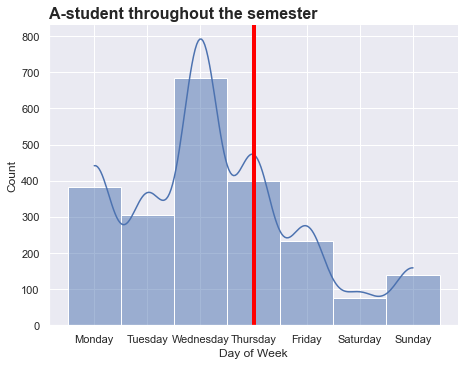

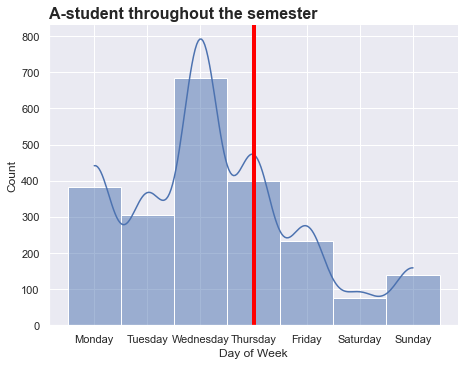

In [458]:
sns.displot(wh_sem282, x= 'Day of Week', kde = True)
plt.gcf().set_size_inches(7, 5)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title("A-student throughout the semester", loc='left', fontweight='bold', fontsize=16)

sns.displot(wh_sem282, x= 'Day of Week', kde = True)
plt.gcf().set_size_inches(7, 5)
plt.axvline(x='Thursday', color='red', linewidth=4)
plt.title("A-student throughout the semester", loc='left', fontweight='bold', fontsize=16)

# Final remarks

- we tackled all goals

- we saw how the grades are distributed, in the early and final stages of the semester

- saw the impact and relevance of early grades

- saw we can predict final grades, albeit the model needs finetuning

- understood that the gradebook and activity datasets we got were unbalanced

- should perhaps try elastic net to capture better which day of the week was more relevant to improving the final grade
